<a href="https://colab.research.google.com/github/SelinaWu/COVID_Zipcode_NYC/blob/master/MIT_COVID19_DATATHON_TeamE001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Feature Selection and Clustering module**
# Author Fadoua Khmaissia (f0khma01@louisville.edu)
## This notebook upload the preprocessed dataframe
#### 1- Performs feature selection based on RReliefF and Correlation and Lasso
#### 2- Select the intersection between the subsets chosen by each technique
#### 3- Tresholds for RRelieff and Corretion were based on the assessement of cluster tendencies we chosen


# Importing Libraries and Packages

In [0]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import seaborn as sns

from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from google.colab import auth
from google.cloud import bigquery
import os
auth.authenticate_user()
print('Authenticated')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Authenticated


# Load input data

In [0]:
import pandas as pd 
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Mounting Drive

In [0]:
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive
# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# List of available files

In [0]:
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/DATATHON/"

 Code			       OurHome.nyc.First.Edition.Download.xlsx
 coronavirus-data	       Presentations
 data			       Results
 gmap.html		      'Script - Brainstorming'
 mit-covid-19-datathon.ipynb   visualization
'Mobility data'


In [0]:
# getting list of 
data_files = glob.glob("/content/drive/My Drive/data/COVID_data/*.csv")

In [0]:
# Sort inputs in reverse chronoligical order
data_files = sorted(data_files)[::-1]

# Compute the Target variable defined as IR :  average increase of daily new cases

In [0]:
# Compute average daily cases increase
daily_infection_rate = pd.DataFrame()
df_csv = pd.read_csv(data_files[0], index_col=None, header=0)

daily_infection_rate['MODZCTA'] = df_csv['MODZCTA']
daily_infection_rate['Positive_ref'] = df_csv['Positive']
daily_infection_rate['IR'] = np.nan
for filename in data_files[1:]:
    df_csv = pd.read_csv(filename, index_col=None, header=0)
    #df_csv.rename(columns={'MODZCTA':'geo_id'}, inplace=True)

    daily_infection_rate = pd.merge(daily_infection_rate, df_csv[['MODZCTA', 'Positive']], on = 'MODZCTA', how = 'inner')
    daily_infection_rate[filename.split('/')[-1]] = (daily_infection_rate['Positive_ref'] - daily_infection_rate['Positive'])*100/daily_infection_rate['Positive']
    daily_infection_rate['IR'] = daily_infection_rate[[filename.split('/')[-1],'IR']].mean(axis = 1)
    daily_infection_rate['Positive_ref'] = daily_infection_rate['Positive']
    
    daily_infection_rate = daily_infection_rate.drop(columns=['Positive'])
    

In [0]:
daily_infection_rate.rename(columns={'MODZCTA':'geo_id'}, inplace=True)
daily_infection_rate = daily_infection_rate.iloc[1:]
daily_infection_rate['geo_id'] = daily_infection_rate['geo_id'].astype(int)
#daily_infection_rate.info()
daily_infection_rate['geo_id'] = daily_infection_rate['geo_id'].astype(str)


# Save daily IR

In [0]:
IR_Daily_and_Avge = pd.DataFrame()
IR_Daily_and_Avge['geo_id'] = daily_infection_rate['geo_id']
IR_Daily_and_Avge['IR'] = daily_infection_rate['IR']
IR_Daily_and_Avge[daily_infection_rate.columns[3:][::-1]] = pd.DataFrame(daily_infection_rate[daily_infection_rate.columns[3:][::-1]])
IR_Daily_and_Avge.to_csv('IR_Daily_and_Avge.csv',index=False)
#!cp IR_Daily_and_Avge.csv "drive/My Drive/"
daily_infection_rate = pd.DataFrame(IR_Daily_and_Avge[['geo_id','IR']])
daily_infection_rate.head()

,geo_id,IR
1,10001,10.605568
2,10002,25.340386
3,10003,10.246684
4,10004,0.551049
5,10005,0.765631


# Load merged csv file containing all input features

In [0]:
filename = '/content/drive/My Drive/data/final.csv'
input_data = pd.read_csv(filename, index_col=None, header=0)

In [0]:
input_data = pd.read_csv(filename, index_col=None, header=0)
input_data.shape

(174, 241)

In [0]:
input_data.isnull().values.any()


False

# Feature selection

In [0]:
# X np.array input features
# y np.array target variable
# F List of feature names (list of strings)

from sklearn import linear_model
!pip install sklearn-relief==1.0.0b2
import sklearn_relief as relief

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

def select_features(X,y,normalize): #normalize is 0 or 1 

  if normalize == 1:
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(X) 
    X.loc[:,:] = scaled_values

  corr_FS = dict()
  relief_FS = dict()
  lasso_FS = dict()

  ## Correaltion
  correlation = X.corrwith(y, axis = 0).abs()
  corr_FS['ranked_W'] = sorted(list(correlation))[::-1]
  corr_FS['ranked_idx'] = np.argsort(np.array(list(correlation)))[::-1]

  ## rReliefF
  r = relief.RReliefF(n_features=list(X.shape)[1])# Choose the best 3 features
  my_transformed_matrix = r.fit_transform(np.asarray(X), np.asarray(y))
  relief_FS['ranked_idx'] = np.argsort(r.w_)[::-1]
  relief_FS['ranked_W']  = r.w_[np.argsort(r.w_)[::-1]]

  ## Lasso
  clf = linear_model.Lasso(alpha=0.1)
  clf.fit(X, y)
  lasso_FS['ranked_idx'] = np.argsort(np.abs(clf.coef_))[::-1]
  lasso_FS['ranked_W']  = clf.coef_[np.argsort(clf.coef_)[::-1]]

  return corr_FS, relief_FS, lasso_FS


In [0]:
input_data.columns

Index(['geo_id', 'total_pop', 'households', 'male_pop', 'female_pop',
       'median_age', 'male_under_5', 'male_5_to_9', 'male_10_to_14',
       'male_15_to_17',
       ...
       'in_grades_1_to_4', 'in_grades_5_to_8', 'in_grades_9_to_12',
       'in_school', 'in_undergrad_college', 'IR', 'tripcount', 'tripcount_end',
       'station_count', 'average_riders'],
      dtype='object', length=241)

In [0]:
# Define input and output
y = input_data['IR'] #target variable
input_data.drop(['IR'], axis=1, inplace=True)
input_data.columns
X = input_data.iloc[:,1:] # Raw input features
Features = input_data.columns[1:]
zips = input_data['geo_id'] 

Index(['geo_id', 'total_pop', 'households', 'male_pop', 'female_pop',
       'median_age', 'male_under_5', 'male_5_to_9', 'male_10_to_14',
       'male_15_to_17',
       ...
       'sales_office_employed', 'in_grades_1_to_4', 'in_grades_5_to_8',
       'in_grades_9_to_12', 'in_school', 'in_undergrad_college', 'tripcount',
       'tripcount_end', 'station_count', 'average_riders'],
      dtype='object', length=240)

**Run Feature Selection algorithms**

In [0]:
# Run feature selection 
corr_FS, relief_FS, lasso_FS = select_features(X,y,0)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.81787653711558, tolerance: 7.112868407187919
  positive)


# Select to subset of features 

In [0]:
mask_coor = np.array(corr_FS['ranked_W']) > 0.6 # 0.6 threshold for corr, -10 for relief ## Thresholds are chosen based on trial and error
select_idx = corr_FS['ranked_idx'][mask_coor]
print(Features[mask_coor])
features_Corr = pd.DataFrame()
features_Corr['selected features'] = list(Features[mask_coor])
features_Corr.to_csv('features_corr1.csv',index=False)
!cp features_corr1.csv "drive/My Drive/DATATHON/Results"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


Index(['total_pop', 'households', 'male_pop', 'female_pop', 'median_age',
       'male_under_5', 'male_5_to_9', 'male_10_to_14', 'male_15_to_17',
       'male_18_to_19',
       ...
       'employed_finance_insurance_real_estate', 'employed_information',
       'employed_manufacturing', 'employed_other_services_not_public_admin',
       'employed_public_administration', 'employed_retail_trade',
       'employed_science_management_admin_waste',
       'employed_transportation_warehousing_utilities',
       'employed_wholesale_trade', 'occupation_management_arts'],
      dtype='object', length=113)


In [0]:
#corr_select_idx = select_idx
reduced_data = X.iloc[:,select_idx]



In [0]:
reduced_data.head()

,pop_separated,pop_5_years_over,pop_widowed,pop_now_married,pop_never_married,pop_15_and_over,pop_divorced,male_10_to_14,in_grades_5_to_8,occupation_services,in_grades_9_to_12,high_school_including_ged,occupation_production_transportation_material,children,female_10_to_14,male_15_to_17,some_college_and_associates_degree,high_school_diploma,female_15_to_17,in_school,in_grades_1_to_4,commute_60_more_mins,male_45_64_high_school,one_year_more_college,female_5_to_9,male_5_to_9,employed_transportation_warehousing_utilities,male_45_64_some_college,family_households,employed_retail_trade,aggregate_travel_time_to_work,male_pop,associates_degree,total_pop,pop_determined_poverty_status,population_1_year_and_over,population_3_years_over,income_40000_44999,female_under_5,not_in_labor_force,...,no_car,dwellings_20_to_49_units,tripcount,three_cars,dwellings_1_units_detached,income_125000_149999,rent_10_to_15_percent,two_or_more_races_pop,asian_male_45_54,asian_male_55_64,four_more_cars,asian_pop,median_age,income_200000_or_more,male_45_64_bachelors_degree,commute_20_24_mins,station_count,nonfamily_households,vacant_housing_units_for_sale,male_male_households,bachelors_degree_2,bachelors_degree,gini_index,group_quarters,dwellings_50_or_more_units,housing_built_2000_to_2004,female_female_households,other_race_pop,dwellings_5_to_9_units,employed_science_management_admin_waste,income_150000_199999,different_house_year_ago_different_city,vacant_housing_units_for_rent,management_business_sci_arts_employed,occupation_management_arts,armed_forces,average_riders,commute_25_29_mins,median_year_structure_built,walked_to_work
0,0,0,0,0,0,0,0,104.0,80.0,399.0,114.0,863.0,87.0,770.0,114.0,36.0,818.0,776.0,25.0,824.0,254.0,636.0,144.0,317.0,96.0,175.0,44.0,101.0,1058.0,192.0,0.0,2162.0,400.0,4434.0,4434.0,4343.0,4259.0,36.0,148.0,1118.0,...,131.0,84.0,0.0,180.0,1056.0,239.0,43.0,0.0,0.0,19.0,40.0,245.0,44.9,249.0,145.0,70.0,0.0,835.0,0.0,37.0,781.0,781.0,0.4191,18.0,136.0,0.0,0.0,23.0,39.0,254.0,276.0,99.0,0.0,1157.0,1157.0,0.0,0.0,39.0,1954.0,117.0
1,0,0,0,0,0,0,0,473.0,752.0,1361.0,661.0,2617.0,381.0,3473.0,420.0,339.0,3208.0,2284.0,158.0,5457.0,726.0,3254.0,537.0,1684.0,476.0,429.0,254.0,436.0,4720.0,664.0,418700.0,10378.0,808.0,21896.0,18823.0,21733.0,21278.0,175.0,532.0,8019.0,...,1585.0,1392.0,0.0,221.0,1351.0,647.0,517.0,300.0,72.0,119.0,60.0,1262.0,44.9,1213.0,640.0,565.0,0.0,3878.0,80.0,26.0,3686.0,3686.0,0.5057,3137.0,5143.0,78.0,0.0,236.0,114.0,1338.0,799.0,1041.0,213.0,5783.0,5783.0,0.0,0.0,483.0,1956.0,607.0
2,0,0,0,0,0,0,0,2360.0,4063.0,7874.0,4559.0,11681.0,2798.0,17967.0,2615.0,1627.0,11237.0,10179.0,1489.0,20778.0,4180.0,9831.0,1959.0,6495.0,2625.0,2510.0,2592.0,1424.0,15940.0,2576.0,1332045.0,30595.0,2980.0,67040.0,66700.0,66167.0,64347.0,959.0,2219.0,18279.0,...,9874.0,3773.0,0.0,638.0,4717.0,1300.0,838.0,961.0,149.0,191.0,146.0,2828.0,35.6,1688.0,1329.0,2392.0,0.0,6327.0,178.0,18.0,8873.0,8873.0,0.4653,302.0,6332.0,146.0,55.0,626.0,590.0,3025.0,1501.0,395.0,381.0,12443.0,12443.0,10.0,0.0,1108.0,0.0,1696.0
3,0,0,0,0,0,0,0,657.0,1084.0,3446.0,1197.0,4663.0,1695.0,5902.0,671.0,425.0,2855.0,3523.0,385.0,6057.0,1699.0,3418.0,671.0,1567.0,1089.0,919.0,672.0,408.0,5813.0,1258.0,529430.0,14304.0,796.0,27602.0,25379.0,27222.0,26450.0,404.0,991.0,7880.0,...,7776.0,1568.0,16.0,82.0,210.0,413.0,423.0,630.0,367.0,304.0,13.0,5268.0,33.8,566.0,431.0,845.0,1.0,2999.0,9.0,0.0,3570.0,3570.0,0.4612,2016.0,317.0,135.0,47.0,126.0,1839.0,1712.0,479.0,1004.0,149.0,4788.0,4788.0,0.0,4743.4,332.0,0.0,1255.0
4,0,0,0,0,0,0,0,480.0,827.0,2012.0,1033.0,5077.0,1288.0,3784.0,550.0,366.0,3754.0,4450.0,419.0,5022.0,827.0,3183.0,1126.0,1699.0,503.0,532.0,1023.0,550.0,4682.0,1016.0,411000.0,9208.0,1331.0,18929.0,18914.0,18753.0,18478.0,167.0,433.0,5917.0,...,751.0,142.0,0.0,487.0,3887.0,506.0,60.0,1845.0,424.0,424.0,153.0,4805.0,40.8,306.0,278.0,938.0,0.0,876.0,67.0,0.0,1736.0,1736.0,0.4006,22.0,179.0,0.0,0.0,1507.0,99.0,778.0,593.0,122.0,134.0,2546.0,2546.0,0.0,0.0,260.

In [0]:
input_data.iloc[:,236:].columns

Index(['tripcount', 'tripcount_end', 'station_count', 'average_riders'], dtype='object')

In [0]:
R = pd.DataFrame(reduced_data)

In [0]:
features_Corr = pd.DataFrame()
features_Corr['selected features'] = list(reduced_data.columns)
features_Corr.to_csv('features_corr1.csv',index=False)
!cp features_corr1.csv "drive/My Drive/DATATHON/Results"


# Clustering

In [0]:
#kmeans_2 = KMeans(n_clusters=8).fit(reduced_data)
#ultimate = kmeans_2
census_data_embedded_2 = TSNE(n_components=2).fit_transform(reduced_data)

# **Assign cluster IDs based on the ranking of the average IR among member zips** (For interpretability reasons)

In [0]:

##
covid_data = pd.DataFrame()
covid_data['IR'] = y
cov2 = covid_data.groupby(kmeans_2.labels_).mean()
cov2.shape

sorted_avIR = np.argsort(cov2['IR'])




##
num_clusters = 8
cluster_ids = kmeans_2.labels_[:]

cluster_ids_ = np.zeros(len(cluster_ids)).astype(int)

for j in range(num_clusters):
  mask = cluster_ids == sorted_avIR[j].astype(int)
  cluster_ids_[mask] = j
  


# **Scatter plot of clusters in t-SNE 2D embedded feature space**

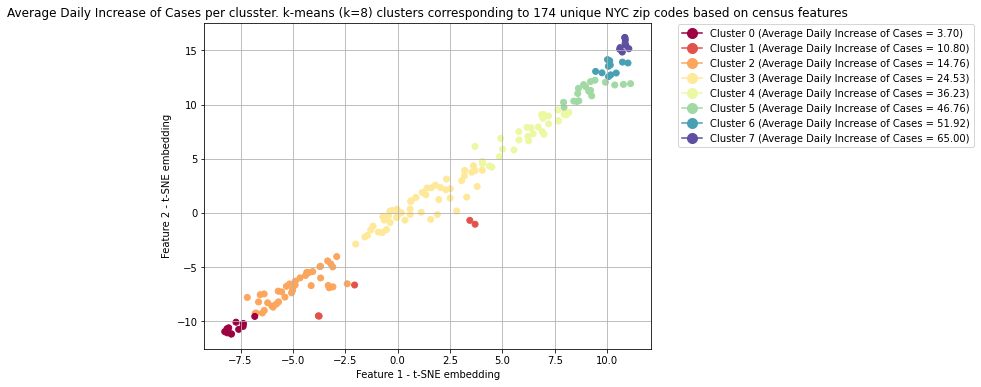

In [0]:
## 
# Create custom legend
from matplotlib.lines import Line2D
from matplotlib import cm
cmaps = cm.get_cmap('Spectral', 8)

#num_clusters = 8
legend_elements = []
measure = np.array(cov2['IR'][sorted_avIR])

for i in range(num_clusters):
 
  legend_elements.append(Line2D([0], [0], marker='o', color=cmaps(i), label='Cluster '+str(i) + ' (Average Daily Increase of Cases = '+str('{:.2f}'.format(measure[i]))+')', markerfacecolor=cmaps(i) , markersize=10))


# Create the figure
# Visualize it:
plt.figure(figsize=(8, 6))
#sns.swarmplot(census_data_embedded_2[:,0], census_data_embedded_2[:,1], c=kmeans_2.labels_.astype(float))
plt.scatter(census_data_embedded_2[:,0], census_data_embedded_2[:,1], c=cluster_ids_.astype(float), cmap = cmaps)
plt.grid()
plt.legend(handles=legend_elements, bbox_to_anchor=[1.05, 1.01])
plt.xlabel('Feature 1 - t-SNE embedding')
plt.ylabel('Feature 2 - t-SNE embedding')
plt.title('Average Daily Increase of Cases per clusster. k-means (k=8) clusters corresponding to 174 unique NYC zip codes based on census features')
plt.show()




In [0]:
##
Zip_clusterIDs_IR = pd.DataFrame()
Zip_clusterIDs_IR = pd.DataFrame(covid_data[['IR']])
Zip_clusterIDs_IR['geo_id'] = zips
Zip_clusterIDs_IR['ClusterID'] = cluster_ids_
Zip_clusterIDs_IR.to_csv('final_ZIP_avIR_clusterIDs.csv',index=False)
!cp final_ZIP_avIR_clusterIDs.csv "drive/My Drive/DATATHON/Results/Clusters"

## **Underlying factors embedding:**Aggregate features by categories

In [0]:
## DEfine feature withing categories indices: (manually done from the saved excel sheet of the selected features)
Familial = reduced_data.iloc[:,np.array([2,4,5,6,8,15,30,45,52,54,70,74])-2]
Age_Gender = reduced_data.iloc[:,np.array([3,7,9,16,17,20,24,26,27,37,38,42,47,48,50,51,53,55,56,57,62,63,65,66,68,69,73,40,33,34,44,87])-2]
Education_level = reduced_data.iloc[:,np.array([10,12,13,18,19,21,22,25,29,61,95,96,34,89])-2]
occupation = reduced_data.iloc[:,np.array([11,14,28,31,41,67,71,72,104,108,109,110,49])-2]
Mobility = reduced_data.iloc[:,np.array([114,112,111,103,91,90,85,79,78,77,76,75,64,32,23,99])-2]
Income = reduced_data.iloc[:,np.array([36,39,43,46,58,59,60,80,81,88,97,105])-2]
Race = reduced_data.iloc[:,np.array([82,83,84,86,102])-2]

In [0]:
factors = [Familial,Age_Gender,Education_level,occupation,Mobility,Income,Race]
factors_IDs = ['Familial','Age_Gender','Education_level','occupation','Mobility','Income','Race']

In [0]:
##embed features
def embed_features(factors,factors_IDs,covid_data,cluster_ids_,zips):
  
  embd_X =  dict()
  for j in range(len(factors)):

    cat1 = TSNE(n_components=1).fit_transform(factors[j])
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(cat1) 
    embd_X[factors_IDs[j]] = list(scaled_values)
    print(j)
    Zip_clusterIDs_IR = pd.DataFrame()
    Zip_clusterIDs_IR = pd.DataFrame(scaled_values)
    Zip_clusterIDs_IR['geo_id'] = zips
    Zip_clusterIDs_IR['ClusterID'] = cluster_ids_
    Zip_clusterIDs_IR.to_csv(factors_IDs[j]+'.csv',index=False)

    #!cp vars()[factors_IDs[j]+'.csv'] "drive/My Drive/DATATHON/Results/Clusters"

    return embd_X

embd_X = embed_features(factors,factors_IDs,covid_data,cluster_ids_,zips)


0


In [0]:
embd_X =  dict()
for j in range(len(factors)):

  cat1 = TSNE(n_components=1).fit_transform(factors[j])
  scaler = MinMaxScaler() 
  scaled_values = scaler.fit_transform(cat1) 
  embd_X[factors_IDs[j]] = scaled_values
  print(j)
  Zip_clusterIDs_IR = pd.DataFrame()
  Zip_clusterIDs_IR = pd.DataFrame(scaled_values)
  Zip_clusterIDs_IR['geo_id'] = zips
  Zip_clusterIDs_IR['ClusterID'] = cluster_ids_
  Zip_clusterIDs_IR.to_csv(factors_IDs[j]+'.csv',index=False)

0
1
2
3
4
5
6


In [0]:
#"drive/My Drive/DATATHON/Results/Clusters"
factors_IDs

['Familial',
 'Age_Gender',
 'Education_level',
 'occupation',
 'Mobility',
 'Income',
 'Race']

In [0]:
## Save 1D embedded factors for geo plots
!cp Familial.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Age_Gender.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Education_level.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp occupation.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Mobility.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Income.csv "drive/My Drive/DATATHON/Results/Clusters"
!cp Race.csv "drive/My Drive/DATATHON/Results/Clusters"

# **Boxplot of the embedded factors grouped by clusters**

In [0]:
filename = '/content/drive/My Drive/DATATHON/Results/Clusters/embedded_features.csv'
embedded_Cats = pd.read_csv(filename, index_col=None, header=0)
embedded_Cats.head()
ref = embedded_Cats['ClusterID']

In [0]:
embedded_Cats.drop(columns=['ClusterID'])

,Familial,Age_Gender,Education_level,occupation,Mobility,Income,Race
0,0.084536,0.065665,0.876152,0.862447,0.000001,0.000000,0.116901
1,0.181849,0.179008,0.804295,0.718391,0.144257,0.112878,0.228025
2,0.805610,0.697310,0.232879,0.243008,0.824774,0.777811,0.419871
3,0.316300,0.265273,0.754214,0.725829,0.214609,0.201798,0.601757
4,0.185985,0.149419,0.786290,0.781787,0.139859,0.112610,0.584196
...,...,...,...,...,...,...,...
169,0.566066,0.633050,0.348378,0.905404,0.772290,0.691876,0.418860
170,0.841337,0.838072,0.180321,0.166593,0.940248,0.911484,0.907581
171,0.880936,0.873148,0.111613,0.106875,0.943761,0.951407,0.308235
172,0.731832,0.726221,0.339847,0.239235,0.891427,0.787861,0.784706


[[None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None]]

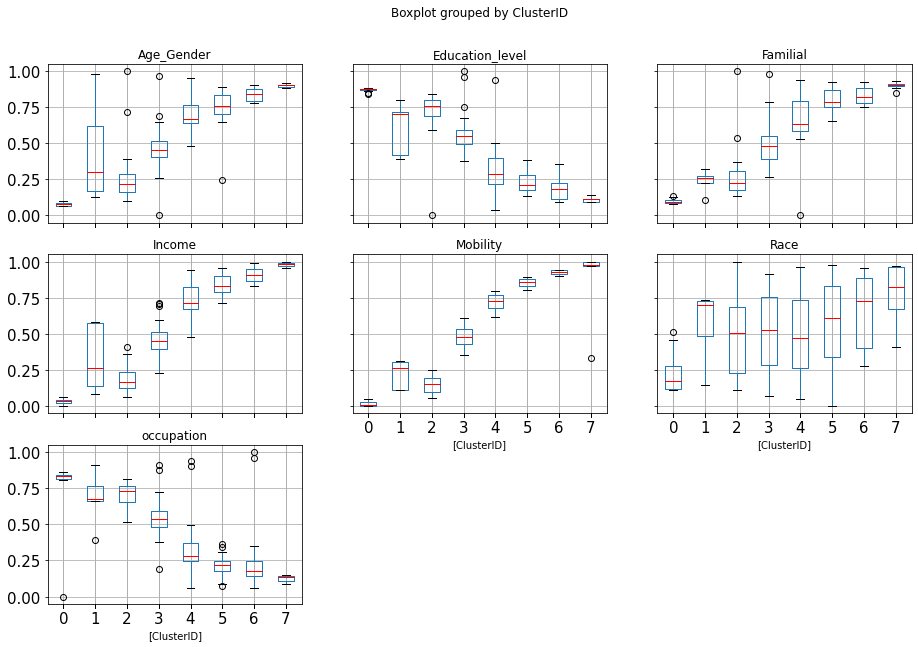

In [0]:
#plt.figure(figsize=(15,10))
bp = embedded_Cats.boxplot(by='ClusterID',figsize=(15,10),return_type='dict', fontsize=15)
#[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
#fig = np.asarray(bp).reshape(-1)[0].get_figure()
[[item.set_color('r') for item in bp[key]['medians']] for key in bp.keys()]

[[None, None, None, None, None, None, None, None]]

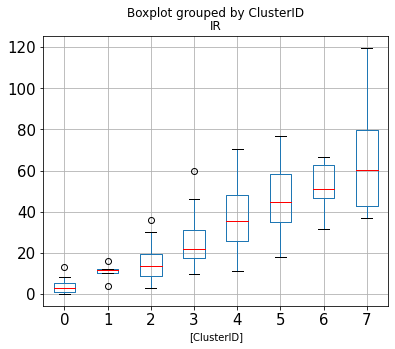

In [0]:

filename = '/content/drive/My Drive/DATATHON/Results/Clusters/CovidIR_Clusters.csv'
embedded_Cats = pd.read_csv(filename, index_col=None, header=0)
#embedded_Cats = embedded_features.csv
#embedded_Cats.reset_index()
#embedded_Cats['Education_level']
embedded_Cats.head()
ref = embedded_Cats['ClusterID']


#plt.figure(figsize=(3,4))
bp = embedded_Cats.boxplot(by='ClusterID',figsize=(6,5),return_type='dict', fontsize=15)
#[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(bp).reshape(-1)]
#fig = np.asarray(bp).reshape(-1)[0].get_figure()
[[item.set_color('r') for item in bp[key]['medians']] for key in bp.keys()]

In [0]:
embd_X.shape

(1, 174, 1)

# Elbow to find clusters

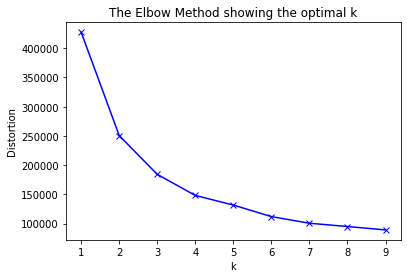

In [0]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(reduced_data)
    kmeanModel.fit(reduced_data)
    distortions.append(sum(np.min(cdist(reduced_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / reduced_data.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()